## Libraries and files

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from matplotlib import patheffects as pe




#My personal pc
#CSV_PATH = r"C:\Users\david\Downloads\OneDrive - Asesoftware S.A.S\Pictures\Equinox AI\Plan semilla\Proyectos\Wine-quality\Outlier treatment\red-removed.csv"
# Asesoftware pc
CSV_PATH_RED = r"C:\Users\jgaravito\OneDrive - Asesoftware S.A.S\Pictures\Equinox AI\Plan semilla\Proyectos\Wine-quality\Outlier treatment\red-removed.csv"
CSV_PATH_WHITE = r"C:\Users\jgaravito\OneDrive - Asesoftware S.A.S\Pictures\Equinox AI\Plan semilla\Proyectos\Wine-quality\Outlier treatment\white-removed.csv"

df_red = pd.read_csv(CSV_PATH_RED, sep=";")
df_white = pd.read_csv(CSV_PATH_WHITE, sep=";")

#With all variables
df_full_red=df_red.copy() 
df_full_white=df_white.copy() 

#Removing quality
X_red=df_red.drop(columns=["quality"])  
X_white=df_white.drop(columns=["quality"])  

#Quality
y_quality_red = df_full_red["quality"].values  
y_quality_white = df_full_white["quality"].values  

# Here i will store the index (numer of cluster) of data
results_df_red=X_red.copy()  
results_df_white=X_white.copy()

## K value methods

Red wines, best K=2?, maybe 4


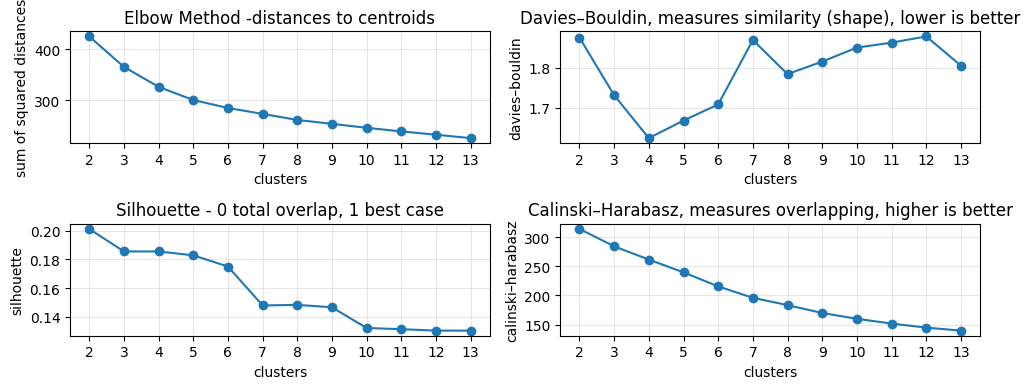

white wines,best K=2


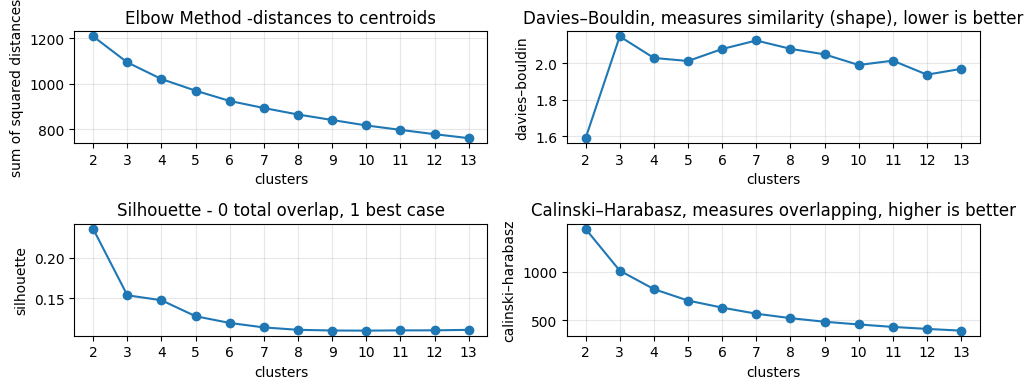

In [14]:
def kmeans_k_selector(X,k_values = range(2, 14)):      

    #from here, to store metrics
    ss = []             
    sil_scores = []           
    ch_scores = []            
    db_scores = []            

    for k_try in k_values:

        km_try = KMeans(n_clusters=k_try, n_init=10, random_state=111) # Define parameters on Kmeans
        labels_try = km_try.fit_predict(X) # calculate clusters and define to which cluster each point "i" belongs

        # elbow 
        ss.append(km_try.inertia_)

        # silhouette coefficient
        sil_scores.append(silhouette_score(X, labels_try))

        # calinski–harabasz index
        ch_scores.append(calinski_harabasz_score(X, labels_try))

        # davies–bouldin index
        db_scores.append(davies_bouldin_score(X, labels_try))



    fig, axs = plt.subplots(2, 2, figsize=(10, 4))

    # elbow method
    axs[0,0].plot(list(k_values), ss, marker="o")
    axs[0,0].set_xticks(list(k_values))
    axs[0,0].set_xlabel("clusters")
    axs[0,0].set_ylabel("sum of squared distances")
    axs[0,0].set_title("Elbow Method -distances to centroids")
    axs[0,0].grid(alpha=0.3)

    # silhouette
    axs[1,0].plot(list(k_values), sil_scores, marker="o")
    axs[1,0].set_xticks(list(k_values))
    axs[1,0].set_xlabel("clusters")
    axs[1,0].set_ylabel("silhouette")
    axs[1,0].set_title("Silhouette - 0 total overlap, 1 best case")
    axs[1,0].grid(alpha=0.3)

    # calinski–harabasz
    axs[1,1].plot(list(k_values), ch_scores, marker="o")
    axs[1,1].set_xticks(list(k_values))
    axs[1,1].set_xlabel("clusters")
    axs[1,1].set_ylabel("calinski–harabasz")
    axs[1,1].set_title("Calinski–Harabasz, measures overlapping, higher is better")
    axs[1,1].grid(alpha=0.3)

    # davies–bouldin
    axs[0,1].plot(list(k_values), db_scores, marker="o")
    axs[0,1].set_xticks(list(k_values))
    axs[0,1].set_xlabel("clusters")
    axs[0,1].set_ylabel("davies–bouldin")
    axs[0,1].set_title("Davies–Bouldin, measures similarity (shape), lower is better")
    axs[0,1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Red wines, best K=2?, maybe 4")
a=kmeans_k_selector(X_red)
print("white wines,best K=2")
b=kmeans_k_selector(X_white)



## Possible outliers + Clustering + Distributions

In [15]:
def Kmeans_EDA(X, k_values, df_full, bins=100):
    cols_to_plot = df_full.select_dtypes(include=[np.number]).columns.tolist()
    X_np = X.to_numpy()

    fig_w, fig_h = 9, 2.5

    # holder for outputs to return
    cluster_dfs_by_k = {}

    for k in k_values:
        # ── KMeans & labels
        km = KMeans(n_clusters=k, n_init=10, random_state=111)
        labels = km.fit_predict(X_np)
        centers = km.cluster_centers_

        # ── Stats per cluster
        dists = np.linalg.norm(X_np - centers[labels], axis=1)
        clusters = np.arange(k)
        cardinality = np.bincount(labels, minlength=k)
        magnitude = np.bincount(labels, weights=dists, minlength=k)

        df_stats = pd.DataFrame({
            "cluster": clusters,
            "cardinality": cardinality,
            "magnitude": magnitude
        })

        # dict of copies per cluster 
        all_cluster_dataframes = {
            c: df_full.iloc[labels == c].copy()
            for c in clusters
        }
        cluster_dfs_by_k[k] = all_cluster_dataframes

        # For plotting convenience only
        cluster_keys = [f"k={k}_cluster#{c}" for c in clusters]
        all_cluster_dataframes_for_plots = {
            f"k={k}_cluster#{c}": all_cluster_dataframes[c]
            for c in clusters
        }

        # ── 1) Cluster sizes
        plt.figure(figsize=(fig_w, fig_h))
        plt.bar(df_stats["cluster"], df_stats["cardinality"], edgecolor='black')
        plt.title(f"k={k}: Cluster sizes")
        plt.xlabel("Cluster")
        plt.ylabel("Cardinality")
        plt.grid(alpha=0.3)
        plt.show()

        # ── 2) Magnitude by cluster
        plt.figure(figsize=(fig_w, fig_h))
        plt.bar(df_stats["cluster"], df_stats["magnitude"], edgecolor='black')
        plt.title("Magnitude")
        plt.xlabel("Cluster")
        plt.ylabel("Magnitude ")
        plt.grid(alpha=0.3)
        plt.show()

        # ── 3) Magnitude vs Cardinality with regression
        plt.figure(figsize=(fig_w, fig_h))
        plt.scatter(df_stats["cardinality"], df_stats["magnitude"])
        for r in df_stats.itertuples():
            plt.annotate(str(r.cluster), (r.cardinality, r.magnitude))
        x = df_stats[["cardinality"]]
        y = df_stats["magnitude"]
        lin = LinearRegression().fit(x, y)
        plt.plot(x.squeeze(), lin.predict(x), linewidth=2)
        plt.title("Magnitude vs Cardinality ")
        plt.xlabel("Cardinality")
        plt.ylabel("Magnitude ")
        plt.grid(alpha=0.3)
        plt.show()

        # ── 4) Per-feature histograms with μ & σ in legend (no table)
        for col in cols_to_plot:
            # Gather all values across clusters to define shared bins
            all_vals = np.concatenate([
                all_cluster_dataframes_for_plots[ck][col].dropna().to_numpy()
                for ck in cluster_keys
            ], dtype=float)

            if all_vals.size == 0:
                continue

            bin_edges = np.histogram_bin_edges(all_vals, bins=bins)

            plt.figure(figsize=(fig_w, fig_h))
            ax = plt.gca()

            for ck in cluster_keys:
                cid = ck.split("#")[-1]
                vals = all_cluster_dataframes_for_plots[ck][col].dropna().to_numpy()
                if vals.size == 0:
                    # still add an entry to keep legend aligned? skip empty clusters entirely
                    continue

                mu = float(np.nanmean(vals))
                sigma = float(np.nanstd(vals, ddof=1))  # sample std

                # Use the bar-style histogram; one label per cluster including μ & σ
                n, b, patches = ax.hist(
                    vals,
                    bins=bin_edges,
                    alpha=0.35,
                    histtype='bar',
                    edgecolor='black',
                    linewidth=0.6,
                    label=f"cluster {cid}  μ={mu:.3g}  σ={sigma:.3g}"
                )

                # Draw mean line with the SAME color as the bars; no label for the line
                line_color = patches[0].get_facecolor() if patches else None
                ax.axvline(mu, linestyle='--', linewidth=1.8, color=line_color)

            ax.set_title(f"{col} (k={k})")
            ax.set_xlabel(col)
            ax.set_ylabel("frequency")

            # De-duplicate legend (matplotlib can duplicate if artists are added later)
            h, l = ax.get_legend_handles_labels()
            if h:
                seen = set()
                h2, l2 = [], []
                for hi, li in zip(h, l):
                    if li not in seen:
                        h2.append(hi); l2.append(li); seen.add(li)
                ax.legend(h2, l2, loc="best", frameon=True, fontsize=8)

            ax.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

    return cluster_dfs_by_k





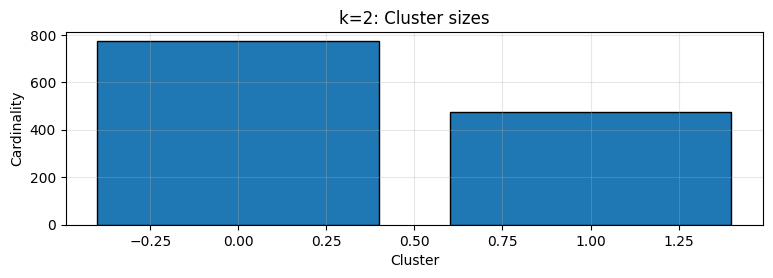

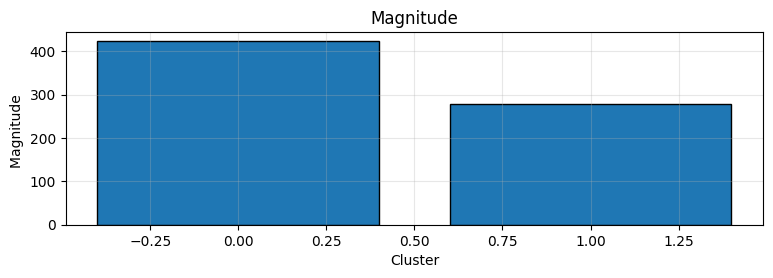

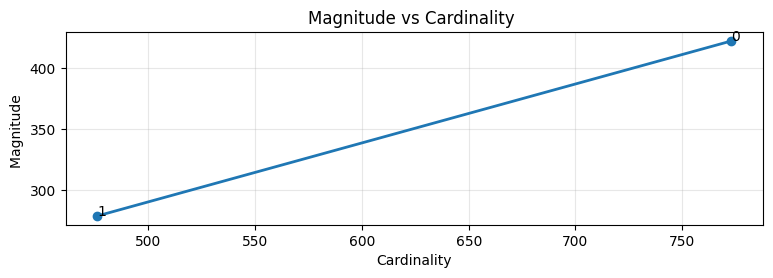

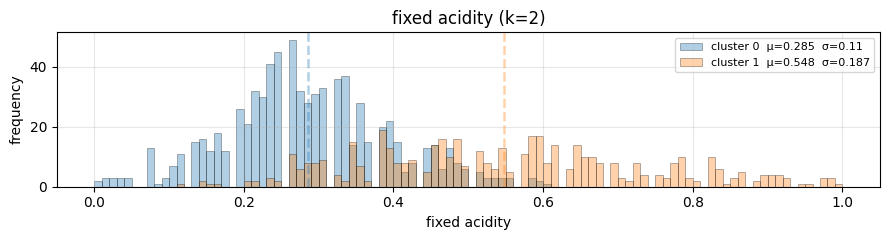

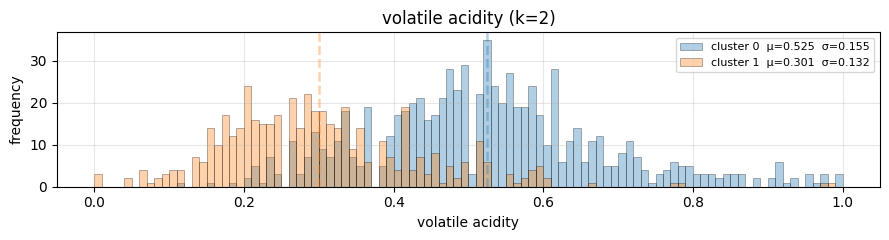

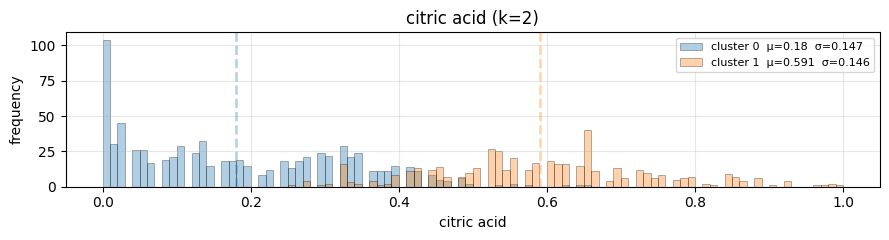

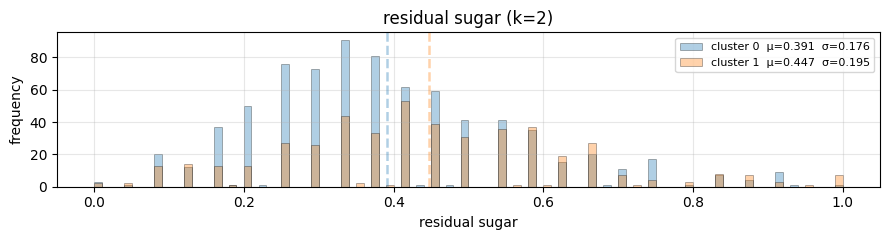

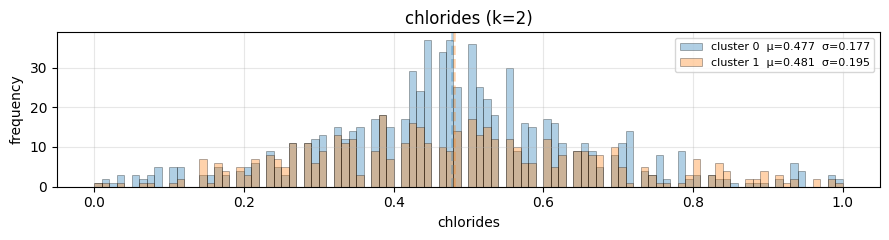

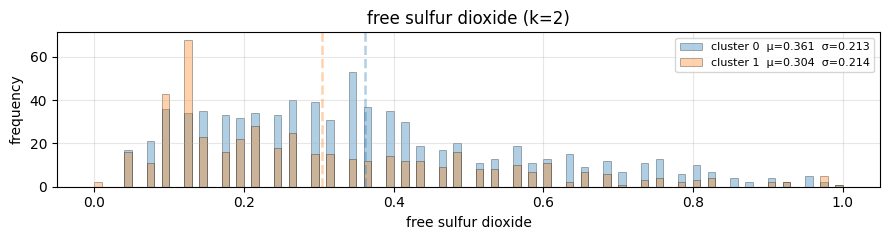

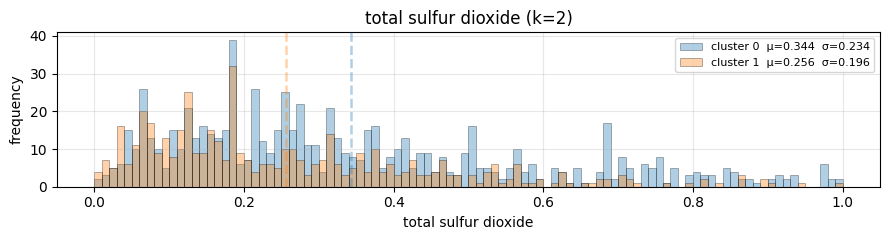

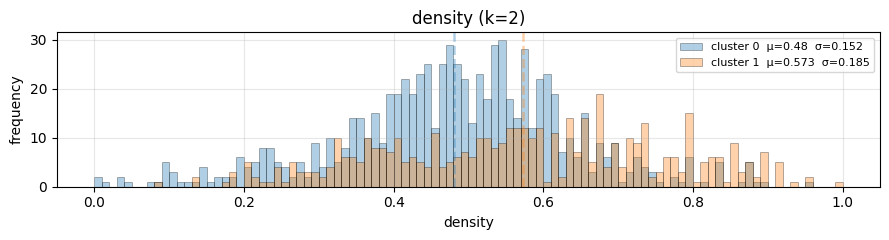

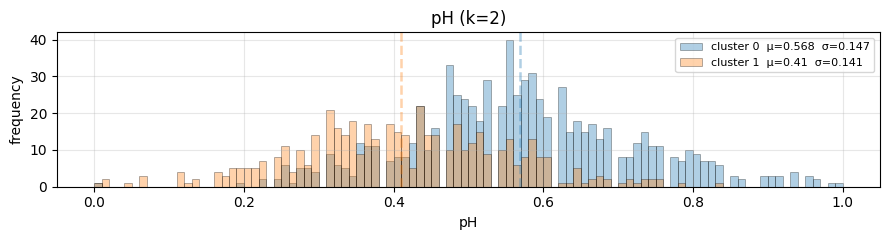

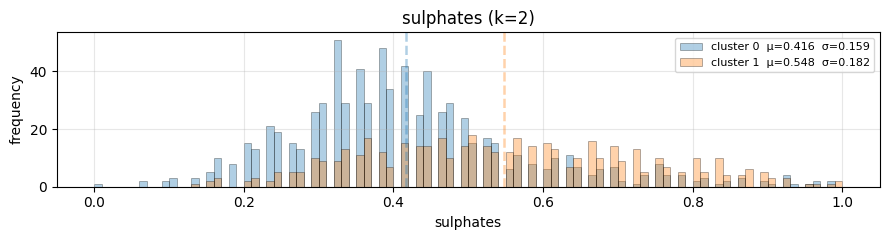

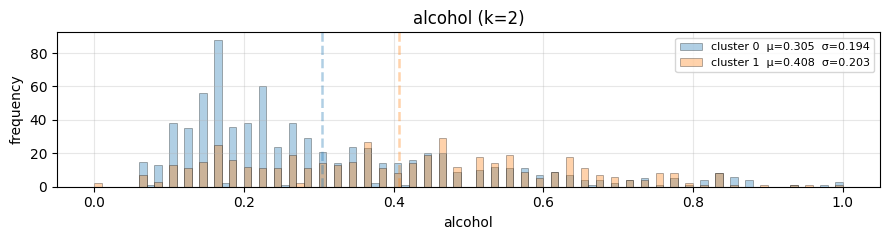

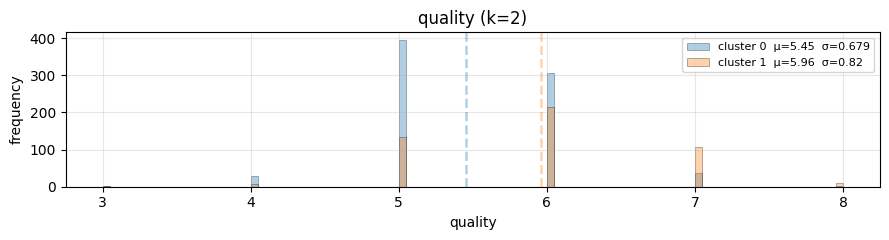

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


In [16]:

from ydata_profiling import ProfileReport
clusters_red=Kmeans_EDA(X_red,[2],df_full_red)
cluster_red_1=clusters_red[2][1]
cluster_red_0=clusters_red[2][0]
description_red_1=cluster_red_1.describe()
description_red_0=cluster_red_0.describe()


report_red_0=ProfileReport(cluster_red_0,title='Cluster 0')
report_red_1=ProfileReport(cluster_red_1,title='Cluster 1')
report_red=report_red_0.compare(report_red_1).to_file('Report_red.html')


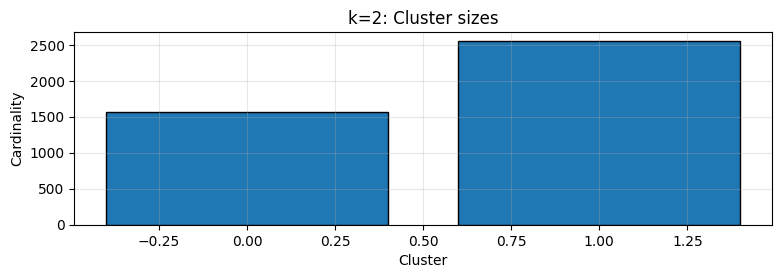

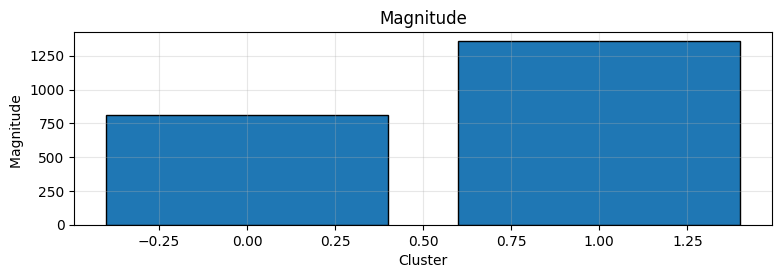

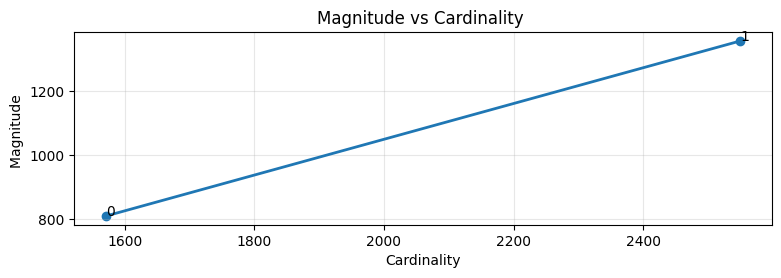

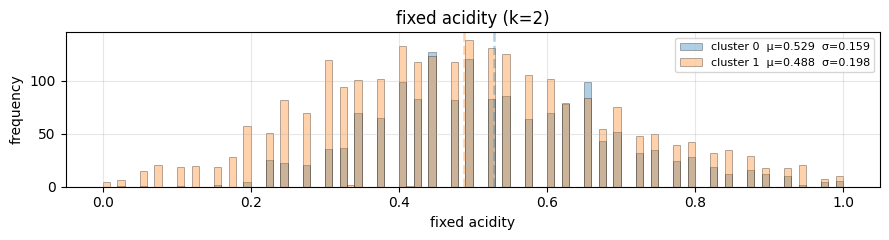

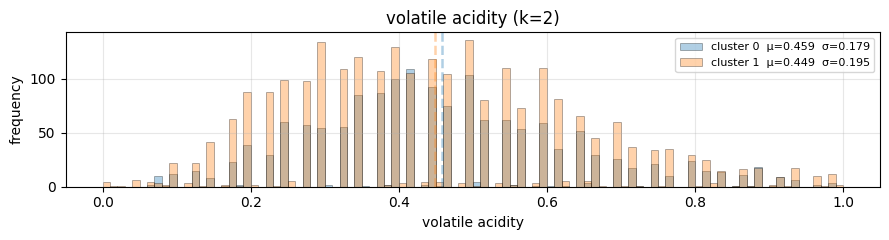

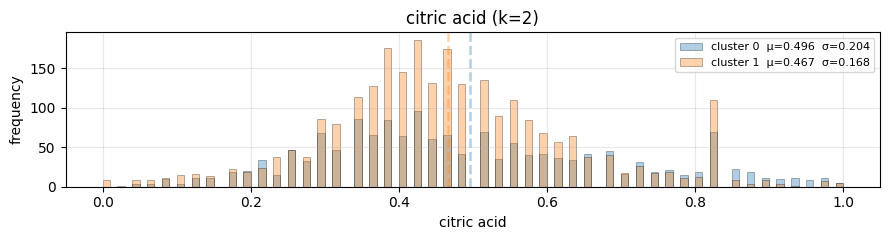

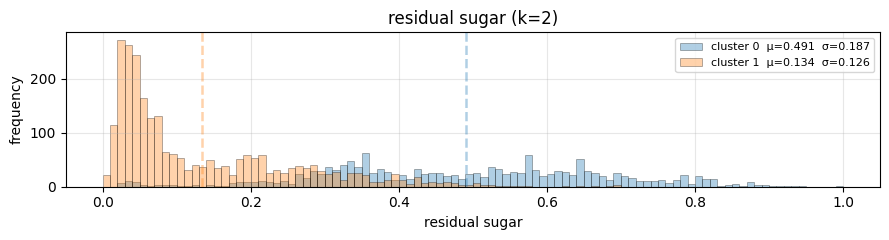

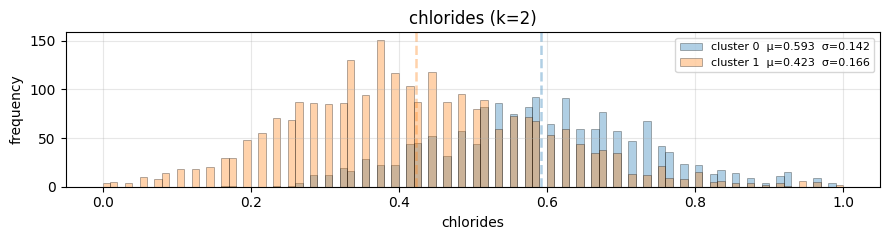

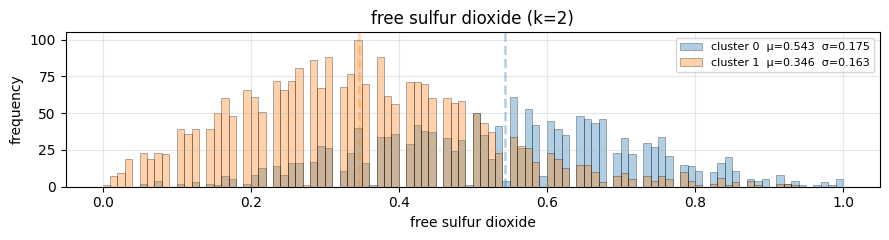

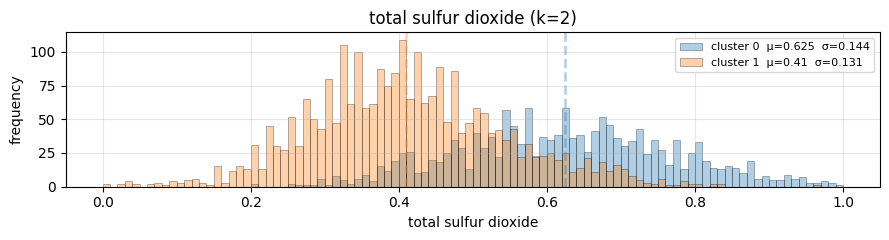

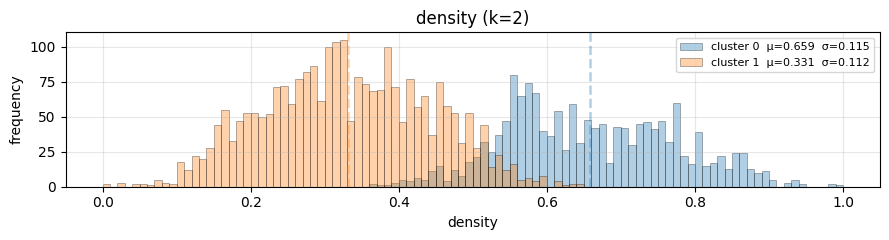

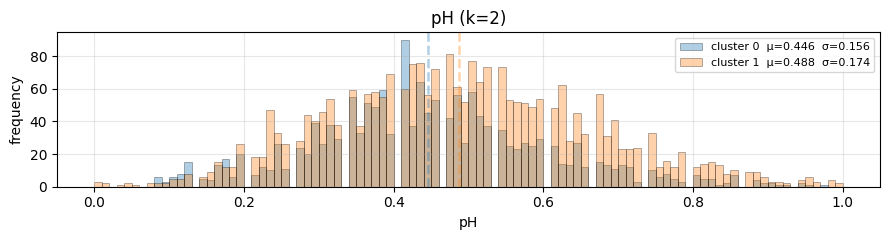

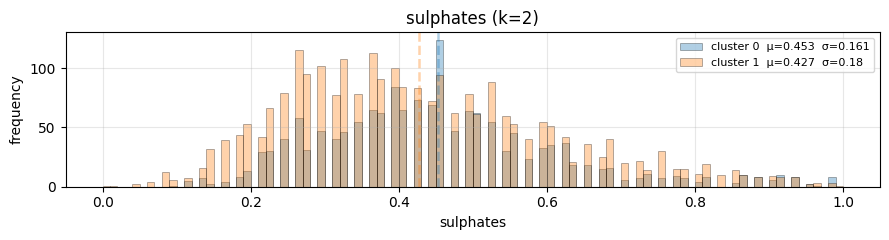

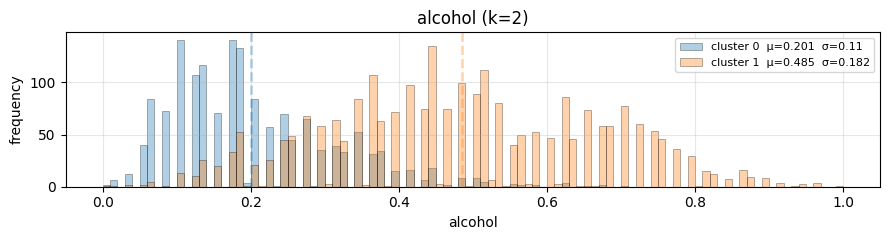

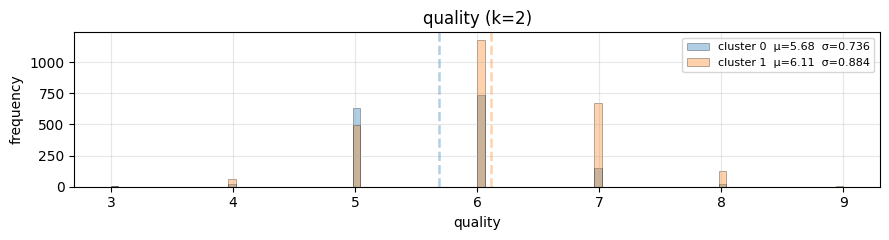

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


In [17]:
clusters_white=Kmeans_EDA(X_white,[2], df_full_white)   
cluster_white_1=clusters_white[2][1]
cluster_white_0=clusters_white[2][0]

report_white=report_white_0.compare(report_white_1).to_file('Report_white.html')